# Cylinder Models

In this section, we describe models of intra-axonal diffusion.
In all cases, the intra-axonal diffusion is represented using axially symmetric cylinder models with $\boldsymbol{\mu}\in\mathbb{S}^2$ the orientation parallel to the cylinder axis.
The three-dimensional diffusion signal in these models is given as the separable product of (free) parallel and restricted perpendicular diffusion *(Assaf et al. 2004)*.
This means that the three-dimensional signal is given by

\begin{equation}
 E_{\textrm{intra}}(\textbf{q},\Delta,\delta,\lambda_\parallel,R) = E_\parallel(q_\parallel,\Delta,\delta,\lambda_\parallel)\times E_\perp(q_\perp,\Delta,\delta,R)
\end{equation}

with parallel q-value $q_\parallel=\textbf{q}^T\boldsymbol{\mu}$, perpendicular q-value $q_\perp=(\textbf{q}^T\textbf{q}-(\textbf{q}^T\boldsymbol{\mu})^2))^{1/2}$, parallel diffusivity $\lambda_\parallel>0$ and cylinder radius $R>0$[mm]. The parallel signal is usually given by Gaussian diffusion as

\begin{equation}
E_\parallel(q_\parallel,\Delta,\delta,\lambda_\parallel)=\exp(-4\pi^2q_\parallel^2\lambda_\parallel(\Delta-\delta/3)).
\end{equation}

The perpendicular signal $E_\perp$ is described using various cylinder models.
In the rest of this section, we start with describing the simplest, having the strongest tissue assumptions (C1), and more towards more general models (C4).

# Stick: C1
The simplest model for intra-axonal diffusion is the ``Stick'' -- a cylinder with zero radius *(Behrens et al. 2003)*.
The Stick model assumes that, because axon diameters are very small, the perpendicular diffusion attenuation inside these axons is negligible compared to the overall signal attenuation.
The perpendicular diffusion coefficient is therefore be approximated by zero, so the perpendicular signal attenuation is always equal to one as $E_\perp=1$.
Inserting this definition into the equation above leads to the simple signal representation

\begin{equation}
E_{\textrm{Stick}}(b,\textbf{n},\boldsymbol{\mu},\lambda_\parallel)=\exp(-b\lambda_\parallel(\textbf{n}^T\boldsymbol{\mu})^2),
\end{equation}

which is the same as a DTI Tensor with $\lambda_\parallel=\lambda_1$ and $\lambda_\perp=\lambda_2=\lambda_3=0$.
Despite its simplicity, it turns out approximating axons as Sticks is quite reasonable at clinical gradient strengths *(Burcaw et al. 2015)*.
In fact, the Stick is used in the most state-of-the-art microstructure models modeling axonal dispersion *(Tariq et al. 2016, Kaden et al. 2016)*.

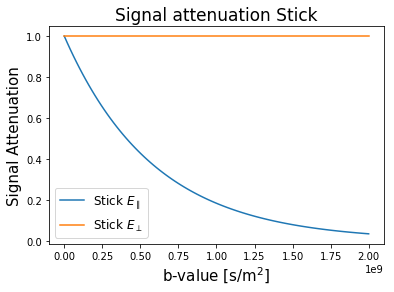

In [1]:
from dmipy.signal_models import cylinder_models
from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
import numpy as np
stick = cylinder_models.C1Stick(mu=[0, 0], lambda_par=1.7e-9)

Nsamples = 100
bvecs_parallel = np.tile(np.r_[0., 0., 1.], (Nsamples, 1))
bvecs_perpendicular = np.tile(np.r_[0., 1., 0.], (Nsamples, 1))
bvals = np.linspace(0, 2e9, Nsamples)
delta = 0.01
Delta = 0.03
scheme_parallel = acquisition_scheme_from_bvalues(bvals, bvecs_parallel, delta, Delta)
scheme_perpendicular = acquisition_scheme_from_bvalues(bvals, bvecs_perpendicular, delta, Delta)

Estick_parallel = stick(scheme_parallel)
Estick_perpendicular = stick(scheme_perpendicular)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(bvals, Estick_parallel, label="Stick $E_\parallel$")
plt.plot(bvals, Estick_perpendicular, label="Stick $E_\perp$")
plt.legend(fontsize=12)
plt.title("Signal attenuation Stick", fontsize=17)
plt.xlabel("b-value [s/m$^2$]", fontsize=15)
plt.ylabel("Signal Attenuation", fontsize=15);

## Stejskal-Tanner Cylinder: C2
In reality, axons have a non-zero radius.
To account for this, different cylinder models for perpendicular diffusion have been proposed for different combinations of PGSE acquisition parameters.
The simplest is the Stejskal-Tanner approximation of the cylinder *(Soderman and Johnson 1995)*, which has the hardest assumptions on the PGSE protocol.
First, it assumes that pulse length $\delta$ is so short that no diffusion occurs during the application of the gradient pulse ($\delta\rightarrow0$).
Second, it assumes that pulse separation $\Delta$ is long enough for diffusion with intra-cylindrical diffusion coefficient $D$ to be restricted inside a cylinder of radius $R$ ($\Delta\gg R^2/D$).
Within these assumptions, the perpendicular, intra-cylindrical signal attenuation is given as

\begin{equation}
 E_\perp(q,R|\delta\rightarrow0,\Delta\gg R^2/D)=\left(\frac{J_1(2\pi q R)}{\pi q R}\right)^2,
\end{equation}

where we use the ``$|$'' to separate function parameters from model assumptions, and $J_1$ is a Bessel function of the first kind. Taking $\lim_{R\rightarrow0}$ of this equation simplifies the three-dimensional Soderman model to the Stick model.

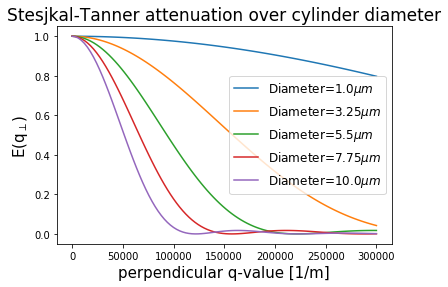

In [2]:
from dmipy.core.acquisition_scheme import acquisition_scheme_from_qvalues
stesjskal_tanner = cylinder_models.C2CylinderStejskalTannerApproximation(mu=[0, 0], lambda_par=1.7e-9)

Nsamples = 100
bvecs_perpendicular = np.tile(np.r_[0., 1., 0.], (Nsamples, 1))
qvals = np.linspace(0, 3e5, Nsamples)
delta = 0.01
Delta = 0.03
scheme_perpendicular = acquisition_scheme_from_qvalues(qvals, bvecs_perpendicular, delta, Delta)

for diameter in np.linspace(1e-6, 1e-5, 5):
    plt.plot(qvals, stesjskal_tanner(scheme_perpendicular, diameter=diameter),
             label="Diameter="+str(1e6 * diameter)+"$\mu m$")
plt.legend(fontsize=12)
plt.title("Stesjkal-Tanner attenuation over cylinder diameter", fontsize=17)
plt.xlabel("perpendicular q-value [1/m]", fontsize=15)
plt.ylabel("E(q$_\perp$)", fontsize=15);

## Callaghan Cylinder: C3
The ``Callaghan'' model relaxes Soderman's $\Delta\gg R^2/D$ assumption to allow for unrestricted diffusion at shorter pulse separation $\Delta$ *(Callaghan 1995)*. In this case, the perpendicular signal attenuation is given as

\begin{align}
 E_\perp(q,\Delta,R|\delta\rightarrow0)&=\sum^\infty_k4\exp(-\beta^2_{0k}D\Delta/R^2)\times \frac{\left((2\pi qR)J_0^{'}(2\pi qR)\right)^2}{\left((2\pi qR)^2-\beta_{0k}^2\right)^2}\nonumber\\
 &+\sum^\infty_{nk}8\exp(-\beta^2_{nk}D\Delta/R^2)\times \frac{\beta^2_{nk}}{\left(\beta_{nk}^2-n^2\right)}\times\frac{\left((2\pi qR)J_n^{'}(2\pi qR)\right)^2}{\left((2\pi qR)^2-\beta_{nk}^2\right)^2}
\end{align}

where $J_n^{'}$ are the derivatives of the $n^{th}$-order Bessel function and $\beta_{nk}$ are the arguments that result in zero-crossings. Taking $\lim_{\Delta\rightarrow\infty}$ of this equation simplifies the Callaghan model to the Soderman model. The Callaghan model has been used to estimate the axon diameter distribution in the multi-compartment AxCaliber approach *(Assaf et al. 2008)*. However, the authors also mention that the perpendicular diffusion is likely already restricted for realistic axon diameters ($<2\mu$m) *(Aboitiz et al. 1992)* for the shortest possible $\Delta$ in PGSE protocols (${\sim}10$ms). This limits the added value of the Callaghan model over the Soderman model in axon diameter estimation.

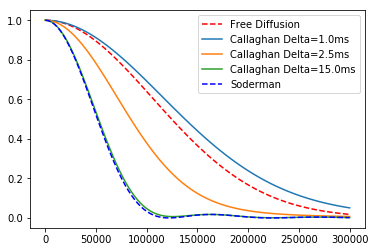

In [3]:
callaghan = cylinder_models.C3CylinderCallaghanApproximation(mu=[0, 0], lambda_par=1e-7)

Nsamples = 100
bvecs_perpendicular = np.tile(np.r_[0., 1., 0.], (Nsamples, 1))
qvals = np.linspace(0, 3e5, Nsamples)
delta = 0.001
Delta = 0.001
scheme_perpendicular = acquisition_scheme_from_qvalues(qvals, bvecs_perpendicular, delta, Delta)
plt.plot(qvals, np.exp(-scheme_perpendicular.bvalues * 1.7e-9), label="Free Diffusion", c='r', ls='--')

for Delta in [0.001, 0.0025, 0.015]:
    scheme_perpendicular = acquisition_scheme_from_qvalues(qvals, bvecs_perpendicular, delta, Delta)
    plt.plot(qvals, callaghan(scheme_perpendicular, diameter=10e-6), label='Callaghan Delta='+str(1e3 * Delta)+'ms')
plt.plot(qvals, stesjskal_tanner(scheme_perpendicular, diameter=10e-6), label="Soderman", c='blue', ls='--')
plt.legend()

For a big cylinder of 10$\mu$ diameter, it can be seen that free diffusion and the Callaghan model are very similar for an extremely short pulse separation of 1ms. The signal is already becoming significantly restricted at 2.5ms, and at 15ms the Callaghan and Soderman approximations have converged (completely restricted).

This shows the problem of using the Callaghan model for axon diameter estimation - for axons of diameter 0.1-2 $\mu$m the diffusion is already restricted around 1 or 2 ms, meaning there is no signal contrast for intra-axonal diffusion when Delta varies. 

## Gaussian Phase Cylinder: C4
The last cylinder model generalization we discuss is the "Van Gelderen" model *(VanGelderen et al. 1994)*, which relaxes the last $\delta\rightarrow0$ assumption to allow for finite pulse length $\delta$. This model is based on the ``Neuman'' model *(Neuman 1974)*, which assumes Gaussian diffusion during the gradient pulse. In this case, the signal attenuation is given as

\begin{equation}
 E_\perp(q,\Delta,\delta,R)=-8\pi^2q^2\sum^\infty_{m=1}\dfrac{\left[2Da_m^2\delta-2 + 2e^{-Da_m^2\delta} + 2e^{-Da_m^2\Delta}-e^{-Da_m^2(\Delta-\delta)}-e^{-Da_m^2(\Delta-\delta)}\right]}{\delta^2D^2a_m^6(R^2a_m^2-1)}
\end{equation}

where $a_m$ are roots of the equation $J_1^{'}(a_mR)=0$, with $J_1^{'}$ again the derivative of the Bessel function of the first kind, and $D$ is the intra-axonal diffusivity.
According to *(Neuman 1974)*, taking the double $\lim_{(\delta,\Delta)\rightarrow(0,\infty)}$ of the equation above should simplify the Van Gelderen model to the Soderman Model, although he does not show this explicitly.
For its generality, the Van Gelderen model has been used in most recent studies regarding in-vivo axon diameter estimation *(Huang et al. 2015, Ferizi et al. 2015, De Santis et al. 2016 )*.

In [4]:
vangelderen = cylinder_models.C4CylinderGaussianPhaseApproximation()

## References

- Aboitiz, Francisco, et al. "Fiber composition of the human corpus callosum." Brain research 598.1 (1992): 143-153.  
- Assaf, Yaniv, et al. "AxCaliber: a method for measuring axon diameter distribution from diffusion MRI." Magnetic resonance in medicine 59.6 (2008): 1347-1354.  
- Assaf, Yaniv, et al. "New modeling and experimental framework to characterize hindered and restricted water diffusion in brain white matter." Magnetic Resonance in Medicine 52.5 (2004): 965-978.  
- Behrens, Timothy EJ, et al. "Characterization and propagation of uncertainty in diffusion‐weighted MR imaging." Magnetic resonance in medicine 50.5 (2003): 1077-1088.  
- Burcaw, Lauren M., Els Fieremans, and Dmitry S. Novikov. "Mesoscopic structure of neuronal tracts from time-dependent diffusion." NeuroImage 114 (2015): 18-37.  
- Callaghan, Paul T. "Pulsed-gradient spin-echo NMR for planar, cylindrical, and spherical pores under conditions of wall relaxation." Journal of magnetic resonance, Series A 113.1 (1995): 53-59.  
- De Santis, Silvia, Derek K. Jones, and Alard Roebroeck. "Including diffusion time dependence in the extra-axonal space improves in vivo estimates of axonal diameter and density in human white matter." NeuroImage 130 (2016): 91-103.  
- Ferizi, Uran, et al. "White matter compartment models for in vivo diffusion MRI at 300mT/m." NeuroImage 118 (2015): 468-483.
- Huang, Susie Y., et al. "The impact of gradient strength on in vivo diffusion MRI estimates of axon diameter." NeuroImage 106 (2015): 464-472.  
- Kaden, Enrico, et al. "Multi-compartment microscopic diffusion imaging." NeuroImage 139 (2016): 346-359.  
- Neuman, C. H. "Spin echo of spins diffusing in a bounded medium." The Journal of Chemical Physics 60.11 (1974): 4508-4511.
- Söderman, Olle, and Bengt Jönsson. "Restricted diffusion in cylindrical geometry." Journal of Magnetic Resonance, Series A 117.1 (1995): 94-97.  
- Tariq, Maira, et al. "Bingham–noddi: Mapping anisotropic orientation dispersion of neurites using diffusion mri." NeuroImage 133 (2016): 207-223.  
- Vangelderen, P., et al. "Evaluation of restricted diffusion in cylinders. Phosphocreatine in rabbit leg muscle." Journal of Magnetic Resonance, Series B 103.3 (1994): 255-260.